# Brain MRI Image classification for Brain Tumor Detection using Transfer Learning

## In this exercise, we'll be performing a binary classification of multiple MRI brain scans by transfer learning (importing and finetuning prebuilt models trained on large dataset with our specific dataset). Here, we're importing an Xception model and it is trained to idenfity possible brain tumor abnormalities in brain scans and identify the existence of tumors by a binary classification of a given scan image having a tumor('yes') or not having a tumor('no')

# By : Karthik Sabareesh


## Github: https://github.com/KarthikSabareesh

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.image as img


from keras.applications import Xception
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
import joblib

### Importing dataset from Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Creating Train and Validation Image Datasets from directories

In [4]:
data_dir =  '/content/drive/MyDrive/brain_tumor_dataset'
img_height, img_width = 224,224
batch_size = 32

In [5]:
train_data = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  label_mode='binary',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  interpolation='nearest',
  batch_size=batch_size)

valid_data = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  label_mode='binary',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  interpolation='nearest',
  batch_size=batch_size)

print(train_data)

Found 253 files belonging to 2 classes.
Using 203 files for training.
Found 253 files belonging to 2 classes.
Using 50 files for validation.
<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>


## Importing Xception model for transfer learning

In [6]:
base_model = Xception(weights='imagenet', include_top=False,input_shape=(img_height,img_width,3))

# Freeze the base model.
for layer in base_model.layers:
    layer.trainable = False

83683744/83683744 [==============================] - 3s 0us/step


In [7]:
rescale = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=[img_height, img_width, 3])
])

## Adding our own layers

In [8]:
tf.random.set_seed(42)

model = keras.Sequential()
model.add(rescale)
model.add(base_model)
model.add(Flatten())
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=32, activation="relu"))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 1)                

In [9]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

## Training our model on our dataset

In [10]:

AUTOTUNE = tf.data.AUTOTUNE

train_data_preprocess = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_data_preprocess = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

callbacks = [EarlyStopping(monitor='loss', patience=3),ModelCheckpoint(filepath='mymodel.h5',verbose=1, save_best_only=True)]

history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=15,
    verbose=1,
    callbacks=callbacks,
)

Epoch 1/15
7/7 [==============================] - ETA: 0s - loss: 3.0612 - accuracy: 0.5764
Epoch 1: val_loss improved from inf to 0.70278, saving model to mymodel.h5
7/7 [==============================] - 102s 10s/step - loss: 3.0612 - accuracy: 0.5764 - val_loss: 0.7028 - val_accuracy: 0.8000
Epoch 2/15
7/7 [==============================] - ETA: 0s - loss: 2.6675 - accuracy: 0.6404
Epoch 2: val_loss improved from 0.70278 to 0.58020, saving model to mymodel.h5
7/7 [==============================] - 68s 10s/step - loss: 2.6675 - accuracy: 0.6404 - val_loss: 0.5802 - val_accuracy: 0.7600
Epoch 3/15
7/7 [==============================] - ETA: 0s - loss: 1.4061 - accuracy: 0.7291
Epoch 3: val_loss did not improve from 0.58020
7/7 [==============================] - 57s 8s/step - loss: 1.4061 - accuracy: 0.7291 - val_loss: 0.8154 - val_accuracy: 0.7600
Epoch 4/15
7/7 [==============================] - ETA: 0s - loss: 1.1727 - accuracy: 0.7586
Epoch 4: val_loss improved from 0.58020 to 0.52

## An overview of loss and accuracy across the epochs

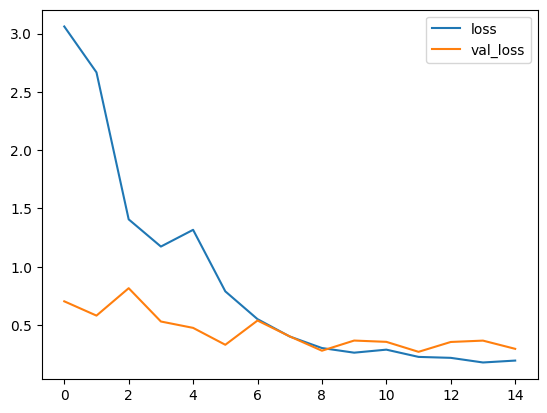

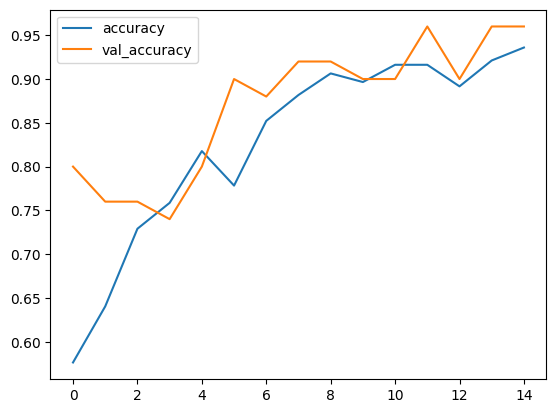

In [11]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

## Reviewing classification with metrics and classification report

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import accuracy_score,f1_score,classification_report


CLASSES = train_data.class_names
probabilities = model.predict(valid_data_preprocess)
print(probabilities)

predictions = [1 if i >0.5 else 0 for i in probabilities]
print(predictions)
unbatched_valid_ds_preprocess = valid_data_preprocess.unbatch()
labels_valid = [int(i[1]) for i in unbatched_valid_ds_preprocess]
print(labels_valid)
list_labels_predictions = np.vstack((labels_valid,predictions)).T
conf_matrix = np.zeros([2,2])

for i,j in list_labels_predictions:
    conf_matrix[i,j] +=1

accuracy = accuracy_score(labels_valid, predictions)
f1 = f1_score(labels_valid, predictions)
print('Val Accuracy: %.2f' % accuracy)
print('Val F1 Score: %.2f' % f1)
print('False positive: %.2f' % (conf_matrix[0,1]/len(predictions)))
print('False negative: %.2f' % (conf_matrix[1,0]/len(predictions)))

2/2 [==============================] - 11s 4s/step
[[9.9999994e-01]
 [5.7385740e-05]
 [4.2477564e-04]
 [1.2006440e-01]
 [9.8540843e-01]
 [1.8539991e-03]
 [2.1357901e-04]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.7510049e-01]
 [9.9994808e-01]
 [2.9419018e-02]
 [1.3062095e-06]
 [9.4506377e-01]
 [9.9995184e-01]
 [9.9929583e-01]
 [4.1351989e-03]
 [9.8764414e-01]
 [6.1260005e-05]
 [9.9262911e-01]
 [9.9997127e-01]
 [9.9994266e-01]
 [7.7149415e-01]
 [4.1144900e-04]
 [3.1593225e-03]
 [9.9972302e-01]
 [9.9978697e-01]
 [9.2306405e-01]
 [9.9985021e-01]
 [9.9449980e-01]
 [9.9847013e-01]
 [9.9989617e-01]
 [2.2634101e-01]
 [7.9335755e-01]
 [9.9995708e-01]
 [9.8609078e-01]
 [3.3060508e-06]
 [8.9971936e-01]
 [9.7180009e-01]
 [9.5856577e-02]
 [9.9999666e-01]
 [9.9962807e-01]
 [9.9967784e-01]
 [9.8958385e-01]
 [2.6575854e-01]
 [6.6517848e-01]
 [9.9952048e-01]
 [3.4913208e-04]
 [8.4102285e-01]
 [1.3893236e-02]]
[1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0

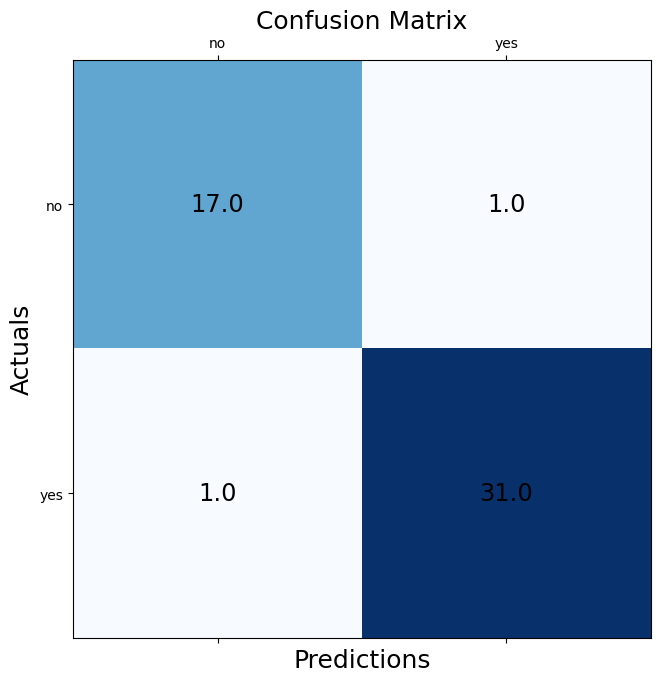

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        18
           1       0.97      0.97      0.97        32

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



In [13]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)

ax.set_yticks([0,1])
ax.set_yticklabels(CLASSES)
ax.set_xticks([0,1])
ax.set_xticklabels(CLASSES)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


print(classification_report(labels_valid,predictions))

In [14]:
model2 = keras.Sequential()
model2.add(rescale)
model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(units=128, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(units=32, activation="relu"))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_3 (Dense)             (None, 128)               12845184  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 1)                

In [15]:
model2.load_weights('mymodel.h5')

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import accuracy_score,f1_score,classification_report


CLASSES = train_data.class_names
probabilities2 = model2.predict(valid_data_preprocess)
print(probabilities2)

predictions2 = [1 if i >0.5 else 0 for i in probabilities2]
print(predictions2)
unbatched_valid_ds_preprocess = valid_data_preprocess.unbatch()
labels_valid = [int(i[1]) for i in unbatched_valid_ds_preprocess]
print(labels_valid)
list_labels_predictions = np.vstack((labels_valid,predictions2)).T
conf_matrix2 = np.zeros([2,2])

for i,j in list_labels_predictions:
    conf_matrix2[i,j] +=1

accuracy2 = accuracy_score(labels_valid, predictions2)
f1_2 = f1_score(labels_valid, predictions2)
print('Val Accuracy: %.2f' % accuracy2)
print('Val F1 Score: %.2f' % f1_2)
print('False positive: %.2f' % (conf_matrix2[0,1]/len(predictions)))
print('False negative: %.2f' % (conf_matrix2[1,0]/len(predictions)))

2/2 [==============================] - 14s 6s/step
[[9.9999976e-01]
 [1.6517980e-02]
 [2.7303828e-04]
 [3.2433029e-02]
 [9.8022783e-01]
 [2.2504698e-03]
 [5.1530031e-04]
 [9.9999994e-01]
 [9.9999762e-01]
 [3.3745396e-01]
 [9.9957168e-01]
 [8.4253423e-02]
 [5.3161575e-06]
 [9.4572753e-01]
 [9.9998885e-01]
 [9.9861658e-01]
 [8.4713966e-02]
 [9.5321852e-01]
 [2.2669425e-03]
 [9.6685356e-01]
 [9.9957615e-01]
 [9.9985117e-01]
 [6.1429018e-01]
 [4.7592325e-03]
 [2.2685284e-02]
 [9.9305886e-01]
 [9.9996632e-01]
 [8.6196685e-01]
 [9.9956429e-01]
 [9.9027056e-01]
 [9.9270338e-01]
 [9.9904263e-01]
 [1.2908459e-01]
 [5.9651154e-01]
 [9.9956822e-01]
 [9.7490168e-01]
 [6.2433101e-04]
 [7.9036546e-01]
 [9.2291743e-01]
 [5.8669850e-02]
 [9.9990433e-01]
 [9.9954575e-01]
 [9.9857008e-01]
 [9.6982247e-01]
 [2.3920339e-01]
 [8.4304082e-01]
 [9.9689180e-01]
 [1.9686355e-03]
 [5.0160694e-01]
 [4.0816497e-02]]
[1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0

In [18]:
joblib.dump(model, '/content/drive/MyDrive/Tumor Detection Model Storage/model_file.joblib')

['/content/drive/MyDrive/Tumor Detection Model Storage/model_file.joblib']

## Hence, we have successfully imported and trained an Xception model for our specific problem to obtain results of 96% accuracy and 97% F1 Score. We've also saved our model to the cloud in Google Drive

# Thank You!!!!